# Lab 8: Multi-objective optimization
In this lab, we will study multi-objective optimization approaches.

For this problem, we will use two problems as benchmarks:
1. Kursawe's function: 
$\underset{x}{min}\begin{cases}f_1(x) &= \sum_{i=1}^{n-1} \left[-10e^{-0.2\sqrt{x_i^2 + x_{i+1}^2}}\right] \\ f_2(x) &= \sum_{i=1}^n \left[|x_i|^{0.8} + 5\sin(x_i)^3\right] \\\end{cases}$ s.t. $x_i \in [-5, 5]; i \in [1,n]$
2. Multiple-disk clutch brake optimization: This real world optimization problem consists in the optimization of 5 paramters concernining multiple-disk clutch brakes. The parameters are shown visually in the image below.
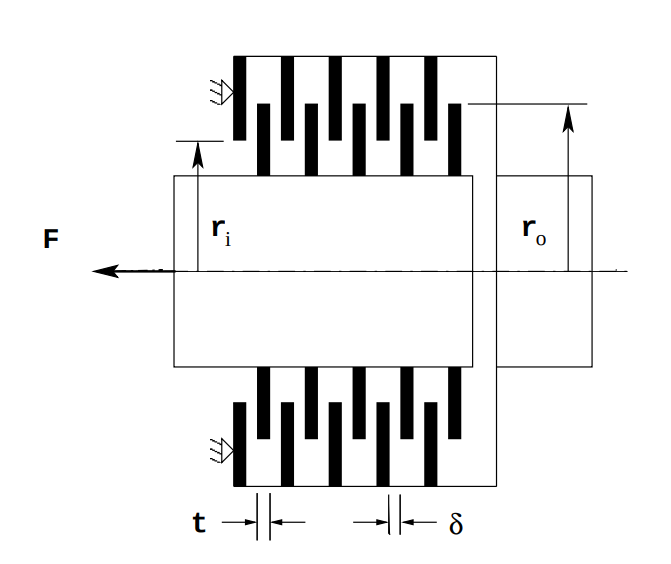

(Image taken from Deb and Srinivasan, "Innovization: Innovative Design Principles Through Optimization")

The goal of the optimization problem is to minimize two objectives: (i) minimization of mass (f1 in kg) of the brake system and (ii) minimization of stopping time (f2 in s).

The remainder of this section contains the implementation of the benchmark functions and utility functions.

For each of the exercises, perform multiple runs (with different random seeds) to reduce the effect of randomness on the results.

In [ ]:
!git clone https://github.com/aarongarrett/inspyred.git inspyred-repo
# Fix some issues in inspyred
!sed -i '254,255d' inspyred-repo/inspyred/ec/ec.py
!sed -i '254i \ \ \ \ \ \ \ \ return all([x == y for x, y in zip(self.candidate, other.candidate)])' inspyred-repo/inspyred/ec/ec.py
!sed -i '107s/ind.candidate\ ==\ a.candidate/all(x\ ==\ y\ for\ x,\ y\ in\ zip(ind.candidate,\ a.candidate))/' inspyred-repo/inspyred/ec/archivers.py
!mv inspyred-repo/inspyred .
!touch __init__.py

Cloning into 'inspyred-repo'...
remote: Enumerating objects: 673, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 673 (delta 8), reused 15 (delta 4), pack-reused 645
Receiving objects: 100% (673/673), 3.06 MiB | 33.02 MiB/s, done.
Resolving deltas: 100% (345/345), done.


In [ ]:
#@markdown Implementation of benchmarks and utilites (double click to open)
import copy
import functools
from pylab import *
from inspyred import benchmarks 
from inspyred.ec.emo import NSGA2
from inspyred.ec.emo import Pareto
from numpy.random import RandomState
from inspyred.ec.variators import mutator
from inspyred.ec import EvolutionaryComputation
from inspyred.ec import terminators, variators, replacers, selectors


def choice_without_replacement(rng, n, size) :
    result = set()
    while len(result) < size :
        result.add(rng.randint(0, n))
    return result

class NumpyRandomWrapper(RandomState):
    def __init__(self, seed=None):
        super(NumpyRandomWrapper, self).__init__(seed)
        
    def sample(self, population, k):
        if isinstance(population, int) :
            population = range(population)           
        
        return asarray([population[i] for i in 
                        choice_without_replacement(self, len(population), k)])
        #return #self.choice(population, k, replace=False)
        
    def random(self):
        return self.random_sample()
    
    def gauss(self, mu, sigma):
        return self.normal(mu, sigma)
    
def initial_pop_observer(population, num_generations, num_evaluations, 
                         args):
    if num_generations == 0 :
        args["initial_pop_storage"]["individuals"] = asarray([guy.candidate 
                                                 for guy in population]) 
        args["initial_pop_storage"]["fitnesses"] = asarray([guy.fitness 
                                          for guy in population]) 
        
def generator(random, args):
    return asarray([random.uniform(args["pop_init_range"][0],
                                   args["pop_init_range"][1]) 
                    for _ in range(args["num_vars"])])

def generator_wrapper(func):
        @functools.wraps(func)
        def _generator(random, args):
            return asarray(func(random, args))
        return _generator

class CombinedObjectives(Pareto):
    def __init__(self, pareto, args):
        """ edit this function to change the way that multiple objectives
        are combined into a single objective
        
        """
        
        Pareto.__init__(self, pareto.values)
        if "fitness_weights" in args :
            weights = asarray(args["fitness_weights"])
        else : 
            weights = asarray([1 for _ in pareto.values])
        
        self.fitness = sum(asarray(pareto.values) * weights)
        
    def __lt__(self, other):
        return self.fitness < other.fitness
        
def single_objective_evaluator(candidates, args):
    problem = args["problem"]
    return [CombinedObjectives(fit,args) for fit in 
            problem.evaluator(candidates, args)]

# parameters, see Deb 2006
Delta_R = 20 # mm
L_max = 30 # mm
delta = 0.5 # mm
p_max = 1 # MPa
V_sr_max = 10 # m/s
n = 250 # rpm
mu = 0.5
s = 1.5
M_s = 40 # Nm
omega = pi * n/30. # rad/s
rho = 0.0000078 # kg/mm^3
T_max = 15 # s
M_f = 3 # Nm
I_z = 55 # kg*m^2

#possible values
values = [arange(60,81,1), arange(90,111,1), arange(1.5,3.5, 0.5), 
          arange(600,1010,10), arange(2,10,1)] 


class DiskClutchBounder(object):    
    def __call__(self, candidate, args):
        closest = lambda target, index: min(values[index], 
                                            key=lambda x: abs(x-target))        
        for i, c in enumerate(candidate):
            candidate[i] = closest(c,i)
        return candidate

class ConstrainedPareto(Pareto):
    def __init__(self, values=None, violations=None, ec_maximize=True):
        Pareto.__init__(self, values)
        self.violations = violations
        self.ec_maximize=ec_maximize
    
    def __lt__(self, other):
        if self.violations is None :
            return Pareto.__lt__(self, other)
        elif len(self.values) != len(other.values):
            raise NotImplementedError
        else:
            if self.violations > other.violations :
                # if self has more violations than other
                # return true if EC is maximizing otherwise false 
                return (self.ec_maximize)
            elif other.violations > self.violations :
                # if other has more violations than self
                # return true if EC is minimizing otherwise false  
                return (not self.ec_maximize)
            elif self.violations > 0 :
                # if both equally infeasible (> 0) than cannot compare
                return False
            else :
                # only consider regular dominance if both are feasible
                not_worse = True
                strictly_better = False 
                for x, y, m in zip(self.values, other.values, self.maximize):                    
                    if m:
                        if x > y:
                            not_worse = False
                        elif y > x:
                            strictly_better = True
                    else:
                        if x < y:
                            not_worse = False
                        elif y < x:
                            strictly_better = True
            return not_worse and strictly_better

class DiskClutchBrake(benchmarks.Benchmark):
    
    def __init__(self, constrained=False) : 
        benchmarks.Benchmark.__init__(self, 5, 2)
        self.bounder = DiskClutchBounder()
        self.maximize = False
        self.constrained=constrained
    
    def generator(self, random, args):
        return [random.sample(values[i],1)[0] for i in range(self.dimensions)]
    
    def evaluator(self, candidates, args):
        fitness = []
        for c in candidates:
            f1 = pi * (c[1] ** 2 - c[0] ** 2) * c[2] * (c[4] + 1) * rho
            
            M_h = ( (2./3.) * mu * c[3] * c[4]  *
                (c[1] ** 3 - c[0] ** 3) /
                (c[1] ** 2 - c[0] ** 2) ) / 1000. # N*m
            T = (I_z * omega) / (M_h + M_f)
            
            f2 = T            
            
            fitness.append(ConstrainedPareto([f1, f2],
                                             self.constraint_function(c),
                                             self.maximize))
            
        return fitness    

    def constraint_function(self,candidate):
        if not self.constrained :
            return 0
        """Return the magnitude of constraint violations."""
        A = pi * (candidate[1] ** 2 - candidate[0] ** 2) # mm^2
        p_rz = candidate[3]/A # N/mm^2
        R_sr = ( (2./3.) * (candidate[1] ** 3 - candidate[0] ** 3) /
                 (candidate[1] ** 2 - candidate[0] ** 2) )  # mm
        V_sr = pi * R_sr * n / 30000. # m/s
        
        M_h = ( (2./3.) * mu * candidate[3] * candidate[4]  *
                (candidate[1] ** 3 - candidate[0] ** 3) /
                (candidate[1] ** 2 - candidate[0] ** 2) ) / 1000. # N*m
        
        T = (I_z * omega) / (M_h + M_f)
        
        violations = 0
        #g_1
        if (candidate[1] - candidate[0] - Delta_R) < 0 :
            violations -= (candidate[1] - candidate[0] - Delta_R) 
        #g_2
        if (L_max - (candidate[4] + 1)*(candidate[2] + delta)) < 0 :
            violations -= (L_max - (candidate[4] + 1)*(candidate[2] + delta))
        #g_3
        if (p_max - p_rz) < 0 :
            violations -= (p_max - p_rz)  
        #g_4
        if (p_max*V_sr_max - p_rz * V_sr) < 0 :
            violations -= (p_max*V_sr_max - p_rz * V_sr)
        #g_5
        if (V_sr_max - V_sr) < 0 :
            violations -= (V_sr_max - V_sr)
        #g_6
        if ( M_h - s * M_s) < 0 :
            violations -= ( M_h - s * M_s) 
        #g_7
        if ( T < 0 ) :
            violations -= T
        #g_8
        if  (T_max - T) < 0 :
            violations -= (T_max - T)

        return violations
    
@mutator    
def disk_clutch_brake_mutation(random, candidate, args):
    mut_rate = args.setdefault('mutation_rate', 0.1)
    bounder = args['_ec'].bounder
    mutant = copy(candidate)
    for i, m in enumerate(mutant):
        if random.random() < mut_rate:
            mutant[i] += random.gauss(0, (values[i][-1] - values[i][0]) / 10.0 )
    mutant = bounder(mutant, args)
    return mutant


def run_nsga2(random, problem, display=False, num_vars=0, use_bounder=True,
        variator=None, **kwargs) :
    """ run NSGA2 on the given problem """
    
    #create dictionaries to store data about initial population, and lines
    initial_pop_storage = {}
 
    algorithm = NSGA2(random)
    algorithm.terminator = terminators.generation_termination 
    if variator is None :     
        algorithm.variator = [variators.blend_crossover,
                              variators.gaussian_mutation]
    else :
        algorithm.variator = variator
    
    kwargs["num_selected"]=kwargs["pop_size"]  
    if use_bounder :
        kwargs["bounder"]=problem.bounder
        
    if "pop_init_range" in kwargs :
        kwargs["generator"]=generator
    else :
        kwargs["generator"]=problem.generator
    final_pop = algorithm.evolve(evaluator=problem.evaluator,  
                          maximize=problem.maximize,
                          initial_pop_storage=initial_pop_storage,
                          num_vars=num_vars, 
                          **kwargs)         
    
    best_guy = final_pop[0].candidate[0:num_vars]
    best_fitness = final_pop[0].fitness
    #final_pop_fitnesses = asarray([guy.fitness for guy in algorithm.archive])
    #final_pop_candidates = asarray([guy.candidate[0:num_vars] for guy in algorithm.archive])
    final_pop_fitnesses = asarray([guy.fitness for guy in final_pop])
    final_pop_candidates = asarray([guy.candidate[0:num_vars] for guy in final_pop])

    return final_pop_candidates, final_pop_fitnesses

def run_ga(random,problem, display=False, num_vars=0, 
           maximize=False, use_bounder=True, **kwargs) :
    """ run a GA on the given problem """
    
    #create dictionaries to store data about initial population, and lines
    initial_pop_storage = {}
    
    algorithm = EvolutionaryComputation(random)
    algorithm.terminator = terminators.generation_termination
    algorithm.replacer = replacers.generational_replacement    
    algorithm.variator = [variators.uniform_crossover, 
                          variators.gaussian_mutation]
    algorithm.selector = selectors.tournament_selection
    algorithm.observer = [initial_pop_observer]
    
    kwargs["num_selected"]=kwargs["pop_size"]  
    if use_bounder :
        kwargs["bounder"]=problem.bounder
    if "pop_init_range" in kwargs :
        kwargs["generator"]=generator
    else :
        kwargs["generator"]=problem.generator
    
    kwargs["problem"] = problem
    final_pop = algorithm.evolve(evaluator=single_objective_evaluator,
                                 maximize=problem.maximize,
                                 initial_pop_storage=initial_pop_storage,
                                 num_vars=num_vars, 
                                 **kwargs)                          

    best_guy = final_pop[0].candidate
    best_fitness = final_pop[0].fitness.fitness
    final_pop_fitnesses = asarray([guy.fitness for guy in final_pop])
    final_pop_candidates = asarray([guy.candidate for guy in final_pop])

    return best_guy, best_fitness

# Exercise 1: Kursawe's function
1. Weighted sum of the objectives: what's the influence of the weights on the output of the search process?

  The weights are use to give more importance in one of the factor

2. Using NSGA-II, plot the Pareto front of the solutions obtained during the optimization process.
3. Compare the weighted-sum method with NSGA-II



In [ ]:
# Instantiate the problem
problem = benchmarks.Kursawe(3)

# Parameters for the GA
args = {}
args["pop_size"] = 50  #@param
args["max_generations"] = 100 #@param

## Weighted sum


Best Individual [-1.457915166104582, -1.3833624215125746, -1.468303088111944]
Best Fitness -11.965312350610372


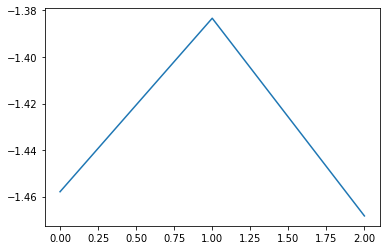

In [ ]:
args["fitness_weights"] = [0.5, 0.5]  # Weights to tune for f1 and f2

rng = NumpyRandomWrapper(0)  # Initialize a random number generator with a seed
    
best_individual, best_fitness = run_ga(
    rng, problem, display=False, num_vars=3, **args
)

print("Best Individual", best_individual)
print("Best Fitness", best_fitness)


## NSGA-II

Final Population
 [[-1.41495966e+00 -1.57636991e+00 -1.45170862e+00]
 [-1.16473344e-02 -4.67584336e-03  4.56741867e-03]
 [-1.51122051e+00 -1.87612908e-04  3.94080916e-04]
 [-5.15291699e-01 -2.34710351e-03  4.38043692e-03]
 [-1.21159528e+00  5.87455888e-03 -7.36968291e-01]
 [-1.02216150e+00 -1.74867147e-03  6.31059384e-05]
 [-6.93604117e-01 -2.05181839e-03  3.70128662e-03]
 [-1.12712944e+00  5.96540796e-03 -1.02245304e+00]
 [-1.34069473e+00 -1.20254443e+00 -1.36771657e+00]
 [-1.34734507e+00 -1.12176999e+00 -1.36244586e+00]
 [-1.34194179e+00 -7.09414840e-03 -8.25741068e-04]
 [-1.17245390e+00 -7.63654987e-03 -1.19435551e+00]
 [-9.36680297e-01  3.39600636e-04  4.43008554e-05]
 [-1.21049968e+00 -1.16738550e-03 -1.02061901e+00]
 [-1.35117760e+00  1.46593154e-02 -1.33452806e+00]
 [-7.54464017e-01 -2.13157530e-03  4.51764449e-05]
 [-1.39342663e+00 -1.37135384e+00 -1.40080124e+00]
 [-9.04853587e-01  3.09589573e-04  7.63048402e-05]
 [-1.08643694e+00  3.57214153e-04  4.83284077e-05]
 [-8.04450056

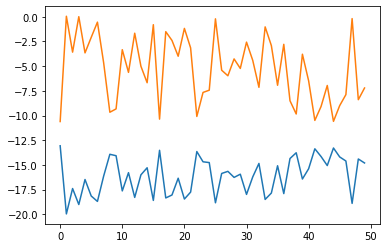

In [ ]:
# parameters for NSGA-2
rng = NumpyRandomWrapper(0)  # Initialize a random number generator with a seed
    
final_pop, final_pop_fitnesses = run_nsga2(
    rng, problem, display=False, num_vars=3, **args
)

print("Final Population\n", final_pop)
print()
print("Final Population Fitnesses\n", final_pop_fitnesses)


# Exercise 2: Multi-disk clutch brake optimization
1. Weighted sum of the objectives: what's the influence of the weights on the output of the search process?

  like in the previous exercice

2. Using NSGA-II, plot the Pareto front of the solutions obtained during the optimization process.
3. Compare the weighted-sum method with NSGA-II


In [ ]:
# parameters for NSGA-2
args = {}
args["pop_size"] = 10 #@param
args["max_generations"] = 10 #@param
args["variator"] = [variators.blend_crossover,disk_clutch_brake_mutation]

problem = DiskClutchBrake(False)  # Initialize the problem

## Weighted sum


In [ ]:
args["fitness_weights"] = [0.5, 0.5]  # Weights to tune for f1 and f2

rng = NumpyRandomWrapper(0)  # Initialize a random number generator with a seed
    
best_individual, best_fitness = run_ga(
    rng, problem, display=False, num_vars=5, **args
)

print("Best Individual", best_individual)
print("Best Fitness", best_fitness)

Best Individual [74, 91, 1.5, 850, 9]
Best Fitness 2.7676087763948045


Final Population
 [[  76.    92.     1.5  950.     3. ]
 [  76.    93.     2.   980.     9. ]
 [  76.    90.     1.5  950.     4. ]
 [  79.    91.     2.   960.     5. ]
 [  80.    91.     2.   960.     4. ]
 [  76.    91.     1.5  950.     6. ]
 [  76.    90.     1.5  970.     8. ]
 [  76.    94.     1.5 1000.     8. ]
 [  76.    90.     1.5  950.     7. ]
 [  76.    91.     1.5  970.     7. ]]

Final Population Fitnesses
 [[ 0.39520733 11.70058789]
 [ 1.40802413  3.82034863]
 [ 0.42711209  8.93935437]
 [ 0.59986827  6.94465517]
 [ 0.46092819  8.60223024]
 [ 0.64452758  5.9594678 ]
 [ 0.76880176  4.41952429]
 [ 1.0122777   4.18245613]
 [ 0.68337934  5.14930497]
 [ 0.73660295  5.01278485]]


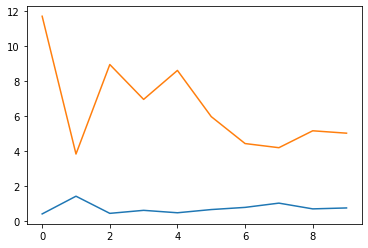

In [ ]:
# parameters for NSGA-2
rng = NumpyRandomWrapper(0)  # Initialize a random number generator with a seed
    
final_pop, final_pop_fitnesses = run_nsga2(
    rng, problem, display=False, num_vars=5, **args
)

print("Final Population\n", final_pop)
print()
print("Final Population Fitnesses\n", final_pop_fitnesses)
plot(final_pop_fitnesses)